# SETUP and UTILS

In [1]:
# !pip install ale-py
# !pip install gymnasium
# !pip install Box2D

from ale_py import ALEInterface
ale = ALEInterface()
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

import gymnasium as gym
import gymnasium.utils.seeding as seeding
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tempfile
import torch

from IPython.display import Image
from collections import deque
from gymnasium.wrappers import RecordVideo
from moviepy.editor import VideoFileClip
from typing import NamedTuple

tempfile.tempdir = './'

# The device to use for PyTorch. Just defined here for convenience.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The default random seed used in the lectures.
DEFAULT_RANDOM_SEED=10

def init_random(env: gym.Env=None, seed=DEFAULT_RANDOM_SEED):
    """Initializes all the random generators used by frameworks to a default value.

    If `env` is specified, it sets also the env random generator and return the env itself. That is
    just a convenient setup for the notebooks, even if arguably not the best structured code setup.
    """
    try:
      random.seed(seed)
      np.random.seed(seed)
      torch.manual_seed(seed)
      # torch.use_deterministic_algorithms(True)
      if env is not None:
          env.np_random, _ = seeding.np_random(seed)
          env.reset(seed=seed)
    except Exception as e:
        print(e)
    return env

def epsilon_gen(eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
    """Generator function for Ɛ and its decay (e.g., exploration via Ɛ-greedy policy)."""
    eps = eps_start
    while True:
        yield eps
        eps = max(eps * eps_decay, eps_min)

def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
    """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_src)."""
    for dest_param, src_param in zip(dest.parameters(), src.parameters()):
        dest_param.data.copy_(tau * src_param.data + (1.0 - tau) * dest_param.data)

class Experience(NamedTuple):
    """A single step / experience of an agent stored in the replay buffer."""
    state:      np.array
    action:     float
    reward:     float
    next_state: np.array
    done:       bool

class ReplayBuffer:
    """Simple replay buffer for off-policy deep reinforcement learning algorithms.

    IMPORTANT: This ReplayBuffer is specifically tuned for the DDPG / TD3 / SAC algorithms in these
    lectures. In particular, the action space is a single float scalar. If you want to adapt those
    algorithms to different environments, you will need to update this code accordingly as well.
    """
    def __init__(self, buffer_size=int(1e5)):
        """Initializes the buffer with an internal deque of size `buffer_size`."""
        self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        """Stores a single step / experience of an agent."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size: int = 128):
        """Randomly selects `batch_size` items from the buffer, stacks them, and returns them."""
        all_indices = np.arange(len(self.memory))
        selection = np.random.choice(all_indices, size=batch_size)
        return self.unpack(selection)

    def unpack(self, selection):
        """Given the `selection` of experiences, returns them as a tuple of stacked values.

        This is convenient for the usage in the various learning algorithms so that they don't have
        to do it themselves.
        """
        experiences = [e for i in selection if (e := self.memory[i]) is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states      = torch.from_numpy(np.stack(states)).float().to(DEVICE)
        actions     = torch.from_numpy(np.vstack(actions)).float().to(DEVICE) # NOTE: float scalar!
        rewards     = torch.from_numpy(np.vstack(rewards)).float().to(DEVICE)
        next_states = torch.from_numpy(np.stack(next_states)).float().to(DEVICE)
        dones       = torch.from_numpy(np.vstack(dones, dtype=np.uint8)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

def show_gym_video_recording(name_prefix: str = 'rl-video', folder: str = None):
    """Shows the recorded video of episode 0 of a gym environment."""
    if folder == None:
        folder = tempfile.tempdir
    video_file = os.path.join(folder, f'{name_prefix}-episode-0.mp4')
    video_clip = VideoFileClip(video_file)
    gif_file = os.path.join('./', 'rl-video.gif')
    video_clip.write_gif(gif_file, fps=15)
    video_clip.close()
    return Image(open(gif_file, 'rb').read())

def plot_scores(scores, rolling_window=25):
    """Plots training scores and their running average."""
    avgs = pd.Series(scores).rolling(rolling_window).mean()
    x = np.arange(len(scores))
    plt.figure('Episode scores')
    plt.plot(x, scores, label='Scores')
    plt.plot(x, avgs, 'r', label='Running average')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    return plt.show()

def gym_simulation(env_name: str, agent=None, max_t=1_000, env_kwargs={}):
    """Runs a simulation of an agent in an initialized gym environment and plays the video."""
    sim_env = gym.make(env_name, render_mode="rgb_array_list", **env_kwargs)
    sim_env = init_random(sim_env)
    sim_env = RecordVideo(sim_env, './', lambda i: i == 0)
    state, _ = sim_env.reset()
    for _ in range(max_t):
        action = agent.act(state) if agent is not None else sim_env.action_space.sample()
        next_state, _, terminated, truncated, _ = sim_env.step(action)
        if terminated or truncated:
            break
        state = next_state
    sim_env.close()
    return show_gym_video_recording()

# PPO - Proximal Policy Optimization

At the end of the _policy gradient_ notebook, we identified the techniques used in PPO. The
[PPO algorithm](https://arxiv.org/abs/1707.06347) was inspired by trying to simplify _TRPO_, for
more details please check [this video](https://www.youtube.com/watch?v=KjWF8VIMGiY&list=PLwRJQ4m4UJjNymuBM9RdmB3Z9N5-0IlY0&index=4).

Here are the techniques we are going to implement:

 1. Learn from multiple parallel / vectorized environments.
 2. Use _Generalized Advantage Estimation_, or [GAE](https://arxiv.org/abs/1506.02438).
 3. Reuse recent experiences to learn in mini-batches (even if technically off-policy).
 4. Clip the policy loss and gradients to prevent the policy from derailing.
 5. Use _trajectory segments_ (instead of entire episodes) for learning.

With all of that, we'll be able to land on the Moon with PPO!

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dataclasses import dataclass
from torch.distributions.normal import Normal

import gymnasium as gym

# from util.gymnastics import DEVICE, gym_simulation, init_random

## Environment

In [3]:
lunar_lander_kwargs = {
    'continuous': True,
    'gravity': -10.0,
    'enable_wind': False,
    'wind_power': 15.0,
    'turbulence_power': 1.5,
}

  logger.warn(



MoviePy - Building file ./rl-video.gif with imageio.


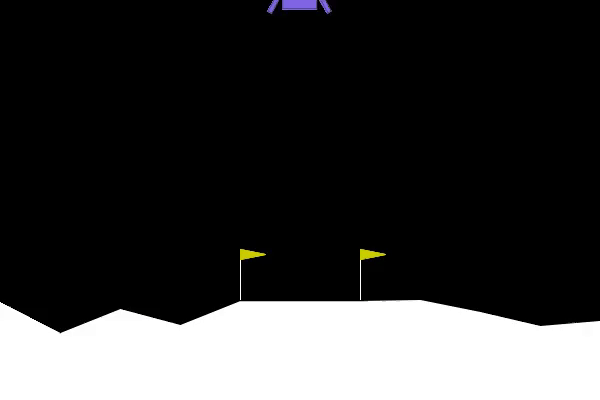

In [4]:
gym_simulation("LunarLander-v3", env_kwargs=lunar_lander_kwargs)

## Trajectory Segments

In PPO learning we don't loop over episodes (and max-steps-per episode). Instead, we learn across
_trajectory segments_, which are stitched together when an episode ends and the next one begins.
That has various advantages, one of which is the ability to better solve long-lasting environments.

For a more in-depth explanation, check out the [CleanRL PPO implementation explanation](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/),
specifically point 1. This implementation has been inspired in many parts by the CleanRL one.

In [5]:
@dataclass
class TrajectorySegment:
    """A trajectory segment collected for PPO training.

    In particular, the segment contains M timesteps for N bots performing actions in the
    environment. So for example `states` has dimension: (M, N, <single_state_dim>).
    """

    states: torch.Tensor    # (M, N, S_dim)
    """The states for the N bots collected for M timesteps."""
    actions: torch.Tensor   # (M, N, A_dim)
    """The actions taken by the N bots in the M timesteps."""
    logprobs: torch.Tensor  # (M, N)
    """The log-probabilty of the action for the N bots in the M timesteps."""
    values: torch.Tensor    # (M, N)
    """The estimated state value for the N bots for the M timesteps."""
    rewards: torch.Tensor   # (M, N)
    """The rewards for the N bots at the M timesteps for the action taken."""
    dones: torch.Tensor     # (M, N)
    """Whether the action taken at the current state transitioned to a terminal state.

    Note that dones[t] refers to whether the state[t+1] is a terminal state. Also, we
    never really store the terminal state in `states` because if the episode completes
    the environment resets and returns the next starting state for a new episode.
    """
    next_start_state: torch.Tensor  # (N, S_dim)
    """The next state from which to start the next trajectory segment collection."""

    def __len__(self):
        return self.states.shape[0]

## Mini-batch Learning

Remember that in REINFORCE we threw away the data collected by the agent every time? That is because
once we learn from the experiences, the policy has changed and we cannot reuse the data sampled by
an old policy to learn... but that sounds quite wasteful...

In PPO, for each trajectory segment we can perform multiple epochs of learning in mini-batches
instead! How is that possible?!

It turns out that, if the old and new policy are "similar enough", we can do gradient ascent using
the gradient of the _ratio_ of the new policy over the old policy times the return (a.k.a., the
_surrogate_ function):

$$
g = \nabla_{\theta'} \sum_{t} \frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)} R^{future}
$$

The only difference in the implementation is that we will use [log probabilities](https://en.wikipedia.org/wiki/Log_probability)
for speed and numerical stability. For an in-depth explanation, see the appendix.

Now that we know that, let's focus on implementing some convenient batching utilities!

In [6]:
@dataclass
class LearningBatch: # Replay Memory types
    """Data used for learning by the Agent.

    The learning batch contains (shuffled and flattened) collected experiences for N environment
    bots, and their corresponding advantages and returns. Assuming the size of the batch is B, then
    for example the `states` dimension is (B, <state_dim>).

    Effectively, the learning batch is a bag of B tuples of:

        (state, action, logprob, advantage, return)

    Each tuple represents a single environment bot collected experience, hence the experiences in
    the learning batch can be randomly of different bots and in different `quantities` (in the
    case of mini-batches).
    """
    states: torch.Tensor        # (B, S_dim)
    actions: torch.Tensor       # (B, A_dim)
    logprobs: torch.Tensor      # (B)
    advantages: torch.Tensor    # (B)
    returns: torch.Tensor       # (B)

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, key):
        """Ability to slice a learning batch in mini-batches."""
        return LearningBatch(self.states[key], self.actions[key], self.logprobs[key],
                             self.advantages[key], self.returns[key])

In [7]:
class Batcher:
    """Helper class to perform mini-batch learning after a trajectory segment is collected.

    In particular, the Batcher:
        * stores the data relevant for learning (segment, advantages, returns)
        * flattens learning data (thanks to the Markovian property)
        * shuffles the (flattened) segment and iterates through it in mini-batches.
    """
    def __init__(self, seg: TrajectorySegment, advantages: torch.Tensor, returns: torch.Tensor,
                 n_mini_batches: int):

        # TODO: Calculate batch_size as the product of the length of rollout times num_bots.
        #       Hint: those values are the sizes of the first two dimension of `states`!
        self.batch_size = seg.states.shape[0] * seg.states.shape[1] # M*N (M timesteps across, N envs)

        # TODO: Calculate mini_batch_size as the integer division of batch_size and n_mini_batches.
        self.mini_batch_size = int(self.batch_size // n_mini_batches)

        # TODO: Flatten the states, actions, logprobs in the trajectory, plus advantages and returns
        #       in a single LearningBatch that will be sliced. Hint: use the `flatten` function
        #       defined below.

        self.experiences = LearningBatch(*Batcher.flatten((seg.states, seg.actions, seg.logprobs, advantages, returns)))

    def shuffle(self):
        """Shuffles the learning data and returns a new mini-batch iterator."""
        # TODO: Get all the indices in the batch and shuffle them. Hint: np.random.shuffle
        indices = np.arange(self.batch_size)
        np.random.shuffle(indices)
        return Batcher.MiniBatchIterator(self.experiences, indices, self.mini_batch_size)

    @staticmethod
    def flatten(t: tuple[torch.Tensor, ...]) -> tuple:
        """Utility function to flatten a multi-agents / bots trajectory segment.

        In particular input tensors have shape (segment_length, num_bots, ...), and they
        are flattened to (segment_length * num_bots, ...).

        That is useful to probe independent experiences (Markovian) from a trajectory.
        """
        return tuple(x.flatten(0, 1) for x in t)

    class MiniBatchIterator:
        """Iterator for a learning batch that loops over mini-batches."""
        def __init__(self, experiences: LearningBatch, indices: list[int], mini_batch_size: int):
            self.experiences = experiences
            self.indices = indices
            self.mini_batch_size = mini_batch_size
            self.start = 0

        def __iter__(self):
            return self

        def __next__(self):
            if self.start >= len(self.experiences):
                raise StopIteration()
            # TODO: Return experiences at the indices[start : (start + mini_batch_size)].
            #       Hint: make sure to update self.start before returning :)
            # ...
            start = self.start
            end = start + self.mini_batch_size
            idxs = self.indices[start:end]
            out = self.experiences[idxs]
            self.start = end
            return out

## PPO Agent

Let's implement the PPO agent! In particular, we will implement the loss function as described in
the paper:

$$
L_t^{CLIP + VF + S}(\theta) = \hat{\mathbb{E}_t}[L_t^{CLIP}(\theta) + c_1 L_t^{VF}(\theta) + c_2 S[\pi_\theta](s_t)]
$$

Which is a combined: policy loss (actor) + value loss (critic) + entropy loss. It is important to
optimize a single loss function when the network share layers and weights of the networks (but we
won't do it here).

### Clipping

As mentioned above, we want the policies to remain "similar". To do that, we clip the _ratio_ in the
interval $[1 - \epsilon, 1 + \epsilon]$, as well as the total gradient of the loss. Check out more
details about clipping in the paper itself!

In [15]:
class Agent(nn.Module):
    """The PPO agent implementing actor-critic learning."""
    def __init__(self, state_size, action_size, lr=2.5e-4, weight_mul=1e-3):
        super().__init__()

        def layer_init(layer, std=np.sqrt(2)):
            """Layer initialization for the neural-network linear layers.

            Scaling the weights might affect learning speed.
            """
            torch.nn.init.orthogonal_(layer.weight, std)
            torch.nn.init.constant_(layer.bias, 0.0)
            layer.weight.data.mul_(weight_mul)
            return layer

        # Critic network
        # TODO: Make a Sequential network with three linear layers (state_size, 32, 1), with tanh
        #       non-linearity. Use `layer_init` above to initialize linear layers. The output is
        #       directly the output of the last linear layer.
        self.critic = nn.Sequential(
            layer_init(nn.Linear(state_size, 256)),
            nn.ReLU(),
            layer_init(nn.Linear(256, 128)),
            nn.ReLU(),
            layer_init(nn.Linear(128, 1))
        )

        # Actor network for the mean... and (log)std deviation parameter below.
        # TODO: Make a Sequential network with three linear layers (state_size, 32, action_size),
        #       with tanh non-linearity. Use `layer_init` above to initialize linear layers. The
        #       output is directly the output of the last linear layer.
        self.actor_mean =  nn.Sequential(
            layer_init(nn.Linear(state_size, 256)),
            nn.ReLU(),
            layer_init(nn.Linear(256, 128)),
            nn.ReLU(),
            layer_init(nn.Linear(128, action_size))
        )

        # TODO: Create a Parameter for the actor logstd.
        self.actor_logstd = nn.Parameter(torch.zeros(1, action_size))

        # TODO: Create the Adam optimizer.
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    @torch.no_grad()
    def act(self, state: np.array):
        """Returns a single action (assuming a single agent) for simulation purposes."""
        action, _ = self.sample_action(torch.from_numpy(state).unsqueeze(0))
        return action.numpy()[0]

    def get_value(self, states):
        """Returns the estimated value of a state given by the critic."""
        # TODO: Return the value from the critic network.
        return self.critic(states)

    def get_action_probs(self, states) -> torch.distributions.Distribution:
        """Returns the probability distribution over the action space.

        Generally, policy-gradient methods assume the continuous actions are sampled from a normal
        distribution (hence, our neural network outputs mean and std of the gaussian).
        """
        # TODO: Get the action mean via the actor network.
        action_mean = self.actor_mean(states)
        # TODO: Get the logstd from the parameter. Hint: use `expand_as` the action_mean
        action_logstd = self.actor_logstd.expand_as(action_mean)
        # TODO: Get the standard deviation exponentiating the logstd.
        action_std = action_logstd.exp()
        # TODO: Return a Normal distribution based on mean and std.
        return Normal(action_mean, action_std)

    def sample_action(self, states):
        """Samples an action using the current policy for the `states` passed as input.

        It returns the action itself, and its log-probability over the action space.
        """
        # TODO: Get the action probabilities calling `get_action_probs`.
        probs = self.get_action_probs(states)

        # TODO: Sample the action.
        action = probs.sample()

        # TODO: Return the action and the log-probability of the action. Hint: you may want to sum
        #       on the first dimention... do you know why?
        # why do I have to do this? - May be for calculation of r_theta - we take a sum of log_probs and divide and then exponentiate? - May lets see
        return action, probs.log_prob(action).sum(1)

    def eval_action(self, states, action):
        """Evaluates an action using the *current* (possibly updated) policy.

        It returns the log-probability of the action, along with the entropy (for entropy loss).
        """
        # TODO: Get the action probabilities for the state.


        probs = self.get_action_probs(states)

        # TODO: Return the logprob of the action, as well as the entropy.
        return probs.log_prob(action).sum(1), probs.entropy().sum(1)

    def learn(self, batch: LearningBatch, entropy_coeff=0.01, vf_coeff=0.5, clip_coeff=0.1,
              max_grad_norm=0.75):

        """PPO learning step on a mini-batch. Paper: https://arxiv.org/abs/1707.06347."""
        # TODO: Get the newlogprobs and entropy via eval_action (of the most recent policy).

        '''
        states: torch.Tensor        # (B, S_dim)
        actions: torch.Tensor       # (B, A_dim)
        logprobs: torch.Tensor      # (B)
        advantages: torch.Tensor    # (B)
        returns: torch.Tensor
        '''

        states, actions = batch.states, batch.actions
        newlogprobs, entropy = self.eval_action(states, actions)

        # TODO: Compute the ratio for the surrogate function. Hint: with logs division becomes
        #       subtraction (we have newlogprobs and the batch.logprobs)...so that we can just
        #       exponentiate afterwards...
        ratio = (newlogprobs - batch.logprobs).exp() # r_theta

        # TODO: Compute the clipped ratio between [1 - clip_coeff, 1 + clip_coeff].
        #       Hint: you may use torch.clamp
        clipped_ratio = ratio.clip(1 - clip_coeff, 1 + clip_coeff)

        # TODO: Get the advantages from the batch for convenience.

        advantages = batch.advantages

        # Policy loss. The actor effectively maximizes the advantages scaled by the probability
        # ratio (~reweighting factor in importance sampling to be able to share previous experiences
        # in a new version of the policy) clipped to effectively keep the policy updates in the
        # vicinity of the previous version.

        # TODO: Compute entropy loss as mean of the entropy times the entropy coefficient.
        L_entropy = entropy_coeff * entropy.mean()

        # TODO: Compute the clipped loss as the min of the advantages times ratio and clipped ratio.
        #       Get the mean, and make sure to _NEGATE_ it.
        L_clipped = -torch.min(ratio*advantages, clipped_ratio*advantages).mean()

        # TODO: Compute the actor loss as difference between clipped loss and entropy loss.
        L_actor = L_clipped - L_entropy

        # TODO: Compute the value loss as the mean squared error of the predicted values vs. the
        #       actual returns.
        L_critic = F.huber_loss(self.get_value(states).squeeze(), batch.returns.squeeze())

        # TODO: Compute the PPO loss as sum of actor loss plus critic loss times its coefficient.
        L_ppo = L_actor + vf_coeff * L_critic
        # TODO: zero_grad the optimizer and call backward.

        self.optimizer.zero_grad()
        # TODO: Clip the gradients too to `max_grad_norm`, to avoid too large of an update.
        #       Hint: use nn.utils.clip_grad_norm_ on the parameters.

        L_ppo.backward()
        nn.utils.clip_grad_norm_(self.actor_mean.parameters(), max_grad_norm)
        nn.utils.clip_grad_norm_(self.critic.parameters(), max_grad_norm)
        self.optimizer.step()

## Advantages and Returns

Recall that intuitively the _advantage_ tells us how much better we are doing taking action $a$ in
state $s$ compared to the "value" of that state (which itself represents the expected return):

$$
A(s_t, a_t) = G_t - V(s_t)
$$

That is the usual / "basic" way of computing advantages: it uses the entire trajectory to compute
the return (in a Monte Carlo fashion). To reduce _variance_, we might want to use bootstrapping and
a current estimate instead. GAE allows to do that, tuning via an extra parameter $\lambda^{GAE}$.

The code for advantages and returns computation is provided. You can easily map the
`basic_advantages_and_returns` method to the formula above, and use the GAE paper to instead dig
deeper into `gae_advantages_and_returns` :)


In [9]:
@torch.no_grad()
def basic_advantages_and_returns(segment: TrajectorySegment, next_return: torch.Tensor, gamma=0.99):
    """Computes returns and advantages for an segment in the "standard" way."""

    returns = torch.zeros_like(segment.rewards).to(DEVICE).detach()

    for t in reversed(range(len(segment))):
        next_non_terminal = 1.0 - segment.dones[t]
        # G_t = R_t + gamma * R_t+1 + gamma^2 * R_t+2 + ...
        returns[t] = segment.rewards[t] + gamma * next_non_terminal * next_return
        # Reset the next_return if an episode terminates half-way (per bot).
        next_return = returns[t] * next_non_terminal

    advantages = returns - segment.values
    return advantages, returns

In [10]:
@torch.no_grad()
def gae_advantages_and_returns(segment: TrajectorySegment, next_return: torch.Tensor, gamma=0.999,
                               gae_lambda=0.98):
    """Compute advantages via generalized advantage estimation (GAE)."""
    advantages = torch.zeros_like(segment.rewards).to(DEVICE)
    last_gae_lambda = 0
    for t in reversed(range(len(segment))):
        next_non_terminal = 1.0 - segment.dones[t]
        td_error = segment.rewards[t] + (
            gamma * next_return * next_non_terminal) - segment.values[t]
        advantages[t] = td_error + gamma * gae_lambda * next_non_terminal * last_gae_lambda
        next_return = segment.values[t]
        # Reset the last_gae_lambda if an episode terminates half-way (per bot).
        last_gae_lambda = advantages[t] * next_non_terminal

    returns = advantages + segment.values
    return advantages, returns

## PPO Training Loop

No surprises here! The loop is basically:

 * Collect a trajectory segment.
 * Compute advantages and returns.
 * Learn in mini-batches for $n$ epochs.
 * Repeat until the environment solved (or max steps).

In [16]:
class PPO:
    """PPO implementation."""
    def __init__(self, env: gym.vector.VectorEnv, agent: Agent, rollout_size=1_024,
                 mini_batch_size=64, n_update_epochs=4, gae_enabled=True, solved_score = 200.0):
        self.env             = env
        self.agent           = agent.to(DEVICE)
        self.num_bots        = 10 # env.num_envs
        self.n_mini_batches  = (rollout_size * self.num_bots) // mini_batch_size
        self.n_update_epochs = n_update_epochs
        self.gae_enabled     = gae_enabled
        self.action_size     = env.action_space.shape[1]
        self.state_size      = env.observation_space.shape[1]
        self.rollout_size    = rollout_size
        self.solved_score    = solved_score
        self.n_episode       = 0 # Number of episode (across all bots)

    def train(self) -> list[float]:
        """PPO training loop."""
        # TODO: Reset the environment.
        start_state, _ = env.reset()
        # TODO: Convert the start state into a tensor.
        start_state    = torch.from_numpy(start_state).to(torch.float32)

        while True:
            # Policy rollout. Given the "vectorized" environment that collects experiences from
            # a different number of bots (10 in this example), we reduce noise.
            # TODO: Collect a trajectory segment calling `collect_trajectory_segment`.
            segment = self.collect_trajectory_segment(start_state)

            # Advantages and returns computation for the learning phase (GAE or standard).
            # TODO: Compute the `next_return` (estimate) using the critic (i.e., the agent get_value
            #       method).

            '''
            TrajectorySegment:

            states: torch.Tensor    # (M, N, S_dim) # """The states for the N bots collected for M timesteps."""
            actions: torch.Tensor   # (M, N, A_dim) # """The actions taken by the N bots in the M timesteps."""
            logprobs: torch.Tensor  # (M, N) # """The log-probabilty of the action for the N bots in the M timesteps."""
            values: torch.Tensor    # (M, N) # """The estimated state value for the N bots for the M timesteps."""
            rewards: torch.Tensor   # (M, N) # """The rewards for the N bots at the M timesteps for the action taken."""
            dones: torch.Tensor     # (M, N) # """Whether the action taken at the current state transitioned to a terminal state.
            '''
            next_return = self.agent.get_value(segment.next_start_state).flatten()
            # TODO: Gets the advantages and returns using one of the methods above. Hint: GAE is
            #       usually a better choice :)
            advantages, returns = gae_advantages_and_returns(segment, next_return)

            # Policy learning. The agent learns on mini-batches provided by the Batcher.
            # TODO: Create a Batcher for mini-batch learning.
            batcher = Batcher(segment, advantages, returns, n_mini_batches = self.n_mini_batches)
            for _ in range(self.n_update_epochs):
                # TODO: Iterate over mini_batch via the Batcher shuffle() method, and call `learn`
                #       on the agent.
                batch_iterator = batcher.shuffle() # Mini Batch iterator object
                for batch in batch_iterator:
                    agent.learn(batch)

            # Prepare for next rollout.
            start_state = segment.next_start_state

            # Checking scores and overall episode.
            if self.training_checkpoint(segment):
                break

    def collect_trajectory_segment(self, start_state):
        """Collect a trajectory segment for a round of PPO policy rollout."""
        batch_dim = (self.rollout_size, self.num_bots)

        s_states   = torch.zeros(batch_dim + (self.state_size,)).to(DEVICE)
        s_actions  = torch.zeros(batch_dim + (self.action_size,)).to(DEVICE)
        s_logprobs = torch.zeros(batch_dim).to(DEVICE)
        s_values   = torch.zeros(batch_dim).to(DEVICE)
        s_rewards  = torch.zeros(batch_dim).to(DEVICE)
        s_dones    = torch.zeros(batch_dim).to(DEVICE)

        state = start_state
        for step in range(self.rollout_size):
            with torch.no_grad(): # Do not track gradients on policy rollout.
                # TODO: sample_action from the agent.
                action, logprob = self.agent.sample_action(state)
                # TODO: clip the action between -1 and 1.
                #       https://gymnasium.farama.org/environments/box2d/lunar_lander/
                clipped_action = action.clip(-1, 1)
                # TODO: get_value from the agent.
                value = self.agent.get_value(state)

            # TODO: Make a step in the environment.
            # NOTE: if done, the next_state is the new state from which to start a new episode.
            next_state, reward, term, trunc, _ = self.env.step(clipped_action.cpu().numpy())

            s_states[step]   = state
            s_actions[step]  = action
            s_logprobs[step] = logprob
            s_values[step]   = value.flatten()
            s_rewards[step]  = torch.Tensor(reward).to(DEVICE)
            # dones[t] corresponds to whether the state[t+1] was done. But if that's the case, we
            # do not store such state b/c what the environment returns as `next_state` is the reset
            # start state for the new episode. This is relevant for advantage / return computation.
            #   https://gymnasium.farama.org/api/vector/#gymnasium-vector-vectorenv
            s_dones[step]    = torch.Tensor(np.logical_or(term, trunc)).to(DEVICE)

            state = torch.Tensor(next_state).to(DEVICE)      # roll over states to next time step

        segment = TrajectorySegment(s_states, s_actions, s_logprobs, s_values, s_rewards, s_dones, next_start_state = state)

        return segment

    @torch.no_grad()
    def training_checkpoint(self, segment: TrajectorySegment) -> bool:
        """Print statistics and determines whether to terminate training."""
        for t in range(len(segment)):
            for b in range(self.num_bots):
                is_episode_end = segment.dones[t, b] == True
                if is_episode_end:
                    self.n_episode += 1
                    avg_score = np.mean(self.env.return_queue)
                    print(f'\rEpisode {self.n_episode}\tAverage Score: {avg_score:.2f}',
                          end="\n" if self.n_episode % 250 == 0 else "")
                    if avg_score > self.solved_score:
                        print(f'\rEpisode {self.n_episode} solved environment! ' +
                              f'Average Score: {avg_score:.2f}')
                        return True
        return False

In [17]:
vector_env = gym.make_vec("LunarLander-v3", num_envs=10, **lunar_lander_kwargs)

vector_env = gym.wrappers.RecordEpisodeStatistics(vector_env)
env = init_random(vector_env)

agent = Agent(env.observation_space.shape[1], env.action_space.shape[1])
ppo = PPO(env, agent)
ppo.train()

can't set attribute 'np_random'
Episode 250	Average Score: -5768.83
Episode 348	Average Score: -7129.65

KeyboardInterrupt: 

In [ ]:
gym_simulation("LunarLander-v3", agent, env_kwargs=lunar_lander_kwargs)

## Appendix

### Off-Policy Policy Gradient (Intuition)

Recall that the objective of reinforcement learning is to maximize the _expected_ return. Hence, we
work with expectations.

If we want to find out the expected value for a function evaluated on multiple trajectories (e.g.,
the return of a reinforcement learning environment), we just go over all trajectories and multiply
by the probability of that trajectory:

$$
\mathbb{E}[R] = \sum_\tau P(\tau)r(\tau)
$$

Where $r$ gives you the return for the trajectory $\tau$ and $P$ its probability. Let say that the
problem is _parameterized_ by the parameters $\theta$, the equation becomes:

$$
\mathbb{E}[R_\theta] = \sum_\tau P_{\theta}(\tau)r(\tau)
$$

This becomes interesting if we consider new parameters $\theta'$. Let's assume the sampling of
$r(\tau)$ happened under old parameters $\theta$, but we now have updated the parameters to
$\theta'$. We cannot compute the _expected value_ just using the old $r$ with the new $P$, but what
we can do is use a trick:

$$
\mathbb{E}[R_{\theta'}] = \sum_\tau P_{\theta}(\tau) \frac{P_{\theta'}(\tau)}{P_{\theta}(\tau)} r(\tau)
$$

The $\frac{P_{\theta'}(\tau)}{P_{\theta}(\tau)}$ is called the _reweighting factor_, and we can
compute updated _expectations_ using old sampled data (technique called _importance sampling_).

-----

Let's go back to the policy gradient update, the gradient $g$ is:

$$
g = \sum_t \nabla_{\theta} log\pi_{\theta}(a_t | s_t) R_t^{future}
$$

Mathematically, the gradient of $log$ is equivalent to:

$$
g = \sum_t \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} R_t^{future}
$$

Now let's assume we have trajectories (hence, $R_t$) collected under an old policy $\pi_{\theta'}$.
How do we compute the gradient? We can use the reweighting factor:

$$
g = \frac{P_{\theta}(\tau)}{P_{\theta'}(\tau)} \sum_t \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} R_t^{future}
$$

$P$ represents the probability of a trajectory under a certain parameter $\theta$:

$$
P_{\theta}(\tau) = p(s_1) \prod_{t=1}^T \pi_{\theta}(a_t|s_t)p(s_{t+1}|s_t,a_t)
$$

Given that the dynamic of the MDP system (i.e., probabilities $p$) are the same, we get:


$$
\frac{P_{\theta}(\tau)}{P_{\theta'}(\tau)} = \prod_{t=1}^T \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta'}(a_t|s_t)}
$$

Let's integrate this term into the gradient considering causality (we discard the future term to be
integrated with the reward term b/c it turns out we obtain still a good approximation):

$$
g = \sum_t  \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)}
    \prod_{t'=1}^t \frac{\pi_{\theta}(a_{t'}|s_{t'})}{\pi_{\theta'}(a_{t'}|s_{t'})}
    R_t^{future}
$$

That doesn't help much per-se. But if we think about what that fraction represents, we can replace
it with the _marginal_ probabilities of the overall dynamics under the parameterized policies:

$$
g = \sum_t  \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)}
    \frac{\pi_{\theta}^{mrg}(s_t, a_t)}{\pi_{\theta'}^{mrg}(s_t, a_t)}
    R_t^{future}
$$

This still is not useful by itself: to compute the _marginals_ we would need access to the entire
dynamic of the system. But we can rewrite that in this form (by chain rule):

$$
g = \sum_t  \frac{\nabla_{\theta} \pi_{\theta}(a_t | s_t)}{\cancel{\pi_{\theta}(a_t | s_t)}}
    \frac{\pi_{\theta}^{mrg}(s_t)}{\pi_{\theta'}^{mrg}(s_t)}
    \frac{\cancel{\pi_{\theta}(a_t|s_t)}}{\pi_{\theta'}(a_t|s_t)}
    R_t^{future}
$$

Suddenly, if we could just ignore the _state marginals_ we would get a manageble update for
off-policy / importance-sampling policy gradient. [It turns out](https://www.youtube.com/watch?v=LtAt5M_a0dI&list=PL_iWQOsE6TfX7MaC6C3HcdOf1g337dlC9&index=40)
that, if the policies are "close" enough (this is where "proximity" plays a critical role), we can
indeed ignore those marginals (in the sense that we get a bounded error). Which gives us the final
update:

$$
g = \nabla_{\theta} \sum_t \frac{\pi_{\theta}(a_t | s_t)}{\pi_{\theta'}(a_t | s_t)} R_t^{future}
$$

For a formal explanation, see [CS 285: Lecture 5](https://www.youtube.com/watch?v=KZd508qGFt0&list=PL_iWQOsE6TfX7MaC6C3HcdOf1g337dlC9&index=20).